# Self Organizing Map: Unsupervised/Dimensionality Reduction

### Custom python implementation of SOM 
#### Tested with the usual suspect: color map reduced to 2D grid

Self organizing map is a wonderful way to figure out patterns within data set provided. It creates a network (dimensions given by user, usually is 2D for easier visualization) where similar datasets cluster together.


The way SOM works is given below:

1. Your input is a dataset of the dimension n * m. eg n rows with each row having m number of columns


2. You create a random weight matrix of any dimensions ,say (p, j) . Each cell in the weight matrix had m number of values. so essentially you create a random weight matrix of (p,j,m).


3. normalize your data set within values of 0 - 1. In this example we will be using sklearn.preprocessing.MinMaxScaler


4. At this time we will provide a couple of hyperparameters, as given in the below steps


5. Provide a value for number of iterations eg 400/2000,etc


6. Provide a learning rate. You may give a learning rate that remains constant through out the training phase, or you may chose to have a decaying learning rate( this is generally the case, and also what we will be using in our example below). IN case you provide a decaying learning rate, you will have to provide a range of learning rate. eg a starting learning rate and a lower learning range .


7. If you are using decaying learning rate technique, we will also be giving a iteration count, till which we would be decaying our learning rate


8. We will also be giving a starting radius, which will decide our sphere of influence. More on this later.


9. Our last parameter would be tau parameter, which is a decaying degree. This will define how much our radius or learning rate will decay


10. We will run the following number of iteration times:

      -select a random x from our dataset
      
      -for each weight in the weight matrix, calculate the distance(could be euclidean,eg)
      
      -select the weight matrix with the least distance from x. Lets say this weight is W, known as BEST MATCHING UNIT
      
      -based on the radius parameter, calculate the neurons around W which falls within this circumference
      
      -based on the learning rate, recalculate the weights within the sphere of influence
      
      -recalculation will be : w = w + learning_rate*neighborhood_function(radius)*(x_random-w)
      
      -neighborhood function will be  exp(-distance/2 * squared(radius), where distance is the distance between W and this particular weight
      
 
11. At the end of predecided number of iterations, we will have a network of weights. The weights have been dragged, recalculated to resemble similarities between original dataset. leading to clustering of patterns together 


our learning rate decaying will work as:

if iteration< itration_max

    new_learning_rate = starting_learning_rate * exp(-iteration/tau)
    
else

    new_learning_rate = end_learning_rate
            
            
our radius will decay as given:


radius = radius * exp(- iteration/tau )



More details can be found in the following resources:

https://en.wikipedia.org/wiki/Self-organizing_map

https://medium.com/@navdeepsingh_2336/self-organizing-maps-for-machine-learning-algorithms-ad256a395fc5


### Lets proceed to creating some of the utility function that will be used before we write the SOM algorithm

#### significant amount of information has been provided in the doc strings. HOpe you find them useful!

In [2]:
## creating a method to generate input
def create_input_data(number_of_rows, number_of_columns = 3):
    """

        Method returns a 3D data equal to number of rows.
        in this method we wil return a range of colors
        so each row will have random values for 0-255
        for red green blue channel

    """


    return np.random.randint(0,255, (number_of_rows, number_of_columns))

In [7]:

## our distance measure method. we will be using this to calculate distance between random point in dataset and the neuron.

## We will also be using this to identify the weights around the Best Matching Unit, which will undergo reweighing

def calculate_distance(a, b):
    """
    this method would calculate the euclidean distance between
    points a and b.

    essentially this will serve as a distance measure between our
    node and weight neuron.

    """
    ## sqrt(np.sum(a-b))
    return np.linalg.norm(a - b)

In [6]:
def scale_input_data(x):
    """
    
    normalized input to the map to a range of 0-1.
    SOMs work best under scaled inputs.
    Using scikit learn MinMaXScaler. else we could have
    done manually as well.

    """
    return MinMaxScaler(feature_range = (0,1)).fit_transform(x)


In [10]:

## this particular method will calculate distance between a randomly selected X value from data set
## and the neurons in the weight matrix.This will identify the lowest weight neuron(BEST MATCHING UNIT) and return the index of the weight matrix

## the intuition behind this is: lowest weight is the most resembling the dataset selected
def compare_node_with_weight_matrix(x, w):

    _units = {}
    
    for i, j in enumerate(w):
        count = 0
        
        for neuron in j:

            _units[(i,count)] = calculate_distance( x, neuron )
            count += 1

    ## sorting the dictionary according to value of each tuple
    ## where each tuple represents the co ordinates
    return sorted(_units, key = lambda x: _units[x])[0]



In [12]:
## this is our neighborhood function. this will be used to remeasure our weights. the intuition behind this is to slowly reduce
## the sphere of influence so that with more number of iteration, we remeasure more precise number of 
## neurons around the best matching unit

def calculate_degree_of_influence(radius, distance):
    """

    :param radius: the decayed value of radius
    :param distance: the distance between current weight cell and the best matching unit

    """
    denom = 2 * (radius)**2
    if denom > np.finfo(np.float).eps: ## this prevents divide by zero issue. in case number is close to 0, we simply return 0
        return np.exp(- distance/denom) 
    else:
        return 0

In [13]:
def calculate_learning_rate(learning_rate, iteration_max, iteration, tau, final_learning_rate):
    """
        learning rate will start decaying and reach a limit after iteration
        reaches iteration_max value

        if learning rate needs to be decayed, we need to pass not only the
        iteration max as a non zero value, we would also need to pass
        the range of learning rate
        eg: learning_rate = (0.1 , 0.02) 

        the way it will work is

        if iteration< itration_max
            new_learning_rate = learning_rate[0] * exp(-iteration/tau)
        else
            new_learning_rate = learning_rate[1]

    """       
    
    if iteration_max > 0 and final_learning_rate:
        
        if iteration < iteration_max:
            return learning_rate * np.exp(-iteration/tau)
    
        else:

            return final_learning_rate

    else:
        return learning_rate


In [14]:
def decay_radius(radius, time_decay, iteration):
    """
        time decay operation on the initial radius value given

    """
    return radius * np.exp(- iteration/time_decay )


In [16]:

## we will use this method to visualize the final color grid

def plot_in_self_organized_map(net):
    fig = plot.figure()
    # setup axes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, net.shape[0]+1))
    ax.set_ylim((0, net.shape[1]+1))
    ax.set_title('Self-Organising Map after iterations')

    # plot the rectangles
    for x in range(1, net.shape[0] + 1):
        for y in range(1, net.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                        facecolor=net[x-1,y-1,:],
                        edgecolor='none'))
    plot.show()


In [17]:
def update_weights(x, _best_matching_index, weight_matrix, \
                    learning_rate, tau, sigma, iteration, \
                        iteration_max, final_learning_rate):
    """

        how are the weights updated.
        based on sigma parameter, we select the sphere of influence
        w = w + learning_rate*neighborhood_function(sigma)*(x_random-w)

    """

    _best_matching_unit = weight_matrix[_best_matching_index[0]][_best_matching_index[1]]
    radius = decay_radius(sigma, tau, iteration)

    for i, j in enumerate(weight_matrix):
        count = 0
        for neuron in j:

            distance = calculate_distance( np.reshape(_best_matching_index,2), np.reshape((i,count),2) )

            if distance <= radius**2: ## within sphere of influence
                
                degree_of_influence = calculate_degree_of_influence(radius, distance)
                
                learning_rate = calculate_learning_rate(learning_rate, iteration_max, \
                                    iteration, tau, final_learning_rate)
                
                new_weight = neuron + (learning_rate * degree_of_influence * (x - neuron))

                # neuron = new_weight

                weight_matrix[i][count] = new_weight
            
            count+= 1


In [18]:

## our goal will be to visualize the above 3channel 3d color as a 
## 2D color map, with similar colors grouping together closely.
## so reds closes to reds, greens closer to green
## we will use a self organizing map to act as a dimensionality reduction
## technique. once reduced the network would be plotted on matplotlib
## to check if we have actually reduced the dimensions

def self_organize_map(x, size_of_grid, epoch, learning_rate, tau, \
                        sigma, final_learning_rate = 0.02, iteration_max = 0):
    """
        runs a SOM on the given input data.

        :param x: the scaled input to the network

        :param size_of_grid: the size of the weight matrix. expecting a tuple (k,p)
                             remember the weight matrix is k*p*m dimension
                             where each k*p cell is associated with a vector
                             of length m

        :param epoch: int value depicting total number of iterations to be executed

        :param learning_rate: learning rate. for now we will use the same learning rate
                              across all iterations. however generally a decaying learning 
                              rate performs better

        :param tau: tau works as a decaying parameter. we will use the same tau parameter to
                    decay the neighbor hood radius as well as learning rate if applicable

        :param sigma: the sigma value will be used to depict the starting radius
                      after every iteration we will decay the radius using the tau parameter

        :param final_learning_rate: if learning rate needs to be decayed this is the value we will
                                take after iteration count exceeds the iteration_max

        :param iteration_max: this parameter will be used to dictate from which particular 
                            iteration the learning rate will stop decaying
    """
    
    dimensionality_of_input = x.shape[1]
    
    ## random weight matrix initialized.
    weight_matrix = np.random.rand(size_of_grid[0],size_of_grid[1],dimensionality_of_input)

    # sigma = max(weight_matrix[0], weight_matrix[1]) / 2
    for _iteration in range(epoch):

        ## select a random x input
        x_random = x[random.randint(0, x.shape[0]-1)]

        ## compare values of weight matrix with the above selected x_random
        ## we will select the closest neuron - best matching unit BMU
        _best_matching_index = compare_node_with_weight_matrix(x_random,weight_matrix)

        ## once our BMU is selected. we will update the weights around it
        ## based on the neighborhood function as sigma parameter(As radius)
        ## and tau parameter( as decaying option)

        update_weights(x_random,_best_matching_index, \
                            weight_matrix,learning_rate, \
                                tau, sigma, _iteration, iteration_max, final_learning_rate)

    ## our weight_matrix is the network which has learnt the behavior and
    ## correlations between the values. we will plot this grid on a matplot
    ## for visualization aid

    return weight_matrix    




In [23]:

def execute():

    x = scale_input_data(create_input_data(100)) ## we create a 100 row, 3d color map and scale it

    epoch = 2000
    weight_shape = (10,10)
    learning_rate = 0.5
    tau = 1000
    sigma = 5 ## initial radius will be half way of the weight matrix dimension (5x,5y) /2 = 2.5

    weight_matrix = self_organize_map(x, weight_shape,epoch,learning_rate,tau,sigma, iteration_max= 200)

    plot_in_self_organized_map(weight_matrix)
    
    


C:\Users\somak\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


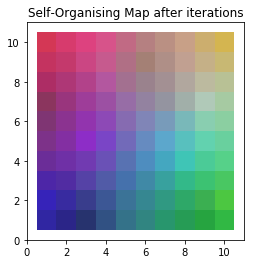

In [24]:
import numpy as np 
from matplotlib import pyplot as plot 
from sklearn.preprocessing import MinMaxScaler
import random
from matplotlib import patches as patches

execute()

### As we can see above, we had an input of 100 rows of RGB values. SOM reduced the dimensions to 2D grid, and at the same time , colors of similar nature have clustered together to form a pattern 